In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import json
from tqdm import tqdm,tqdm_notebook
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train.csv', 'train']


(17500, 2)
(32, 32, 3)


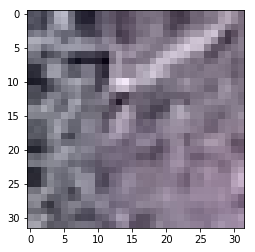

In [2]:
train_df=pd.read_csv("../input/train.csv")
train_df["has_cactus"]=train_df["has_cactus"].map(lambda x:str(x))
print(train_df.shape)

import cv2
image=cv2.imread("../input/train/train/01e30c0ba6e91343a12d2126fcafc0dd.jpg"
                )
plt.imshow(image)
print(image.shape)

In [3]:
from keras.models import Sequential
from keras.layers import (Conv2D, Dense, Flatten, BatchNormalization,
                          Dropout, DepthwiseConv2D, 
                          Flatten,GlobalAveragePooling2D)
from keras.optimizers import Adam
from keras.models import Model
from keras import losses,models,optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

Using TensorFlow backend.


In [4]:
#build model 
#thanks for the kernel https://www.kaggle.com/gabrielmv/aerial-cactus-identification-keras/comments#520479

def creat_model():
    model = Sequential()
        
    model.add(Conv2D(3, kernel_size = 3, activation = 'relu', input_shape = (32, 32, 3)))
    
    model.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 32, kernel_size = 1, activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 128, kernel_size = 1, activation = 'relu'))
    model.add(Conv2D(filters = 256, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 256, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 512, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 512, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 1024, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 1024, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 2048, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    
    model.add(Dense(470, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation = 'tanh'))

    model.add(Dense(1, activation = 'sigmoid'))
    
    opt=optimizers.Adam(0.001)
    model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    return model

In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,
                                 validation_split=0.1,
                                 rotation_range=30,
                                 shear_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True)
train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/train/train",
    x_col="id",
    y_col="has_cactus",
    batch_size=32,
    shuffle=True,
    class_mode="binary",
    target_size=(32,32),
    subset='training')

validation_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../input/train/train",
    x_col="id",
    y_col="has_cactus",
    batch_size=32,
    shuffle=True,
    class_mode="binary",
    target_size=(32,32),
    subset='validation')

Found 15750 images belonging to 2 classes.
Found 1750 images belonging to 2 classes.


In [6]:
model=creat_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 3)         84        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 16)        0         
_________________________________________________________________
depthwise_conv2d_1 (D

In [7]:
model_name="imagegenerator.h5"
mc=ModelCheckpoint(model_name,monitor="val_acc",verbose=1,save_best_only=True,
                  mode="auto")
rl=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=5,verbose=1,
                     min_lr=0.00001)
es=EarlyStopping(monitor="val_loss",min_delta=1e-10,patience=50,verbose=1,
                restore_best_weights=True)
callback_list=[mc,rl,es]
history=model.fit_generator(generator=train_generator,
                            validation_data=validation_generator,
                            validation_steps=int(train_df.shape[0]/32),
                            steps_per_epoch=int(train_df.shape[0]/32),
                            epochs=600,
                            callbacks=callback_list,
                            verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 102s - loss: 0.0799 - acc: 0.8942 - val_loss: 0.2378 - val_acc: 0.7428

Epoch 00001: val_acc improved from -inf to 0.74278, saving model to imagegenerator.h5


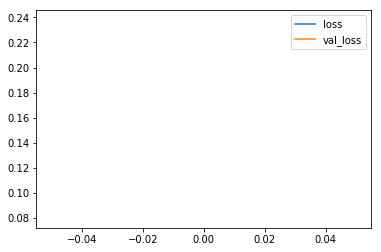

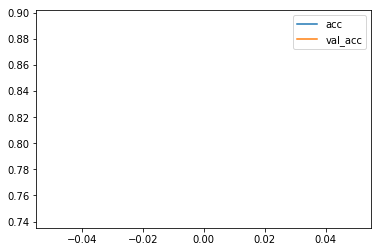

In [8]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [9]:
train_dir=r"../input/train/train/"
test_dir=r"../input/test/test/"
X_test=[]
X_image=[]
for image in tqdm_notebook(os.listdir(test_dir)):
    X_test.append(cv2.imread(test_dir+image))
    X_image.append(image)
X_test=np.array(X_test)
X_test=X_test/255.0

In [10]:
test_predictions=model.predict(X_test)

In [11]:
submission=pd.DataFrame(test_predictions,columns=['has_cactus'])

In [12]:
submission['id'] = ''
cols=list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission=submission[cols]
for i, img in enumerate(X_image):
    submission.set_value(i,'id',img)
print(submission)

                                        id  has_cactus
0     79ac4cc3b082e0a1defe1be601806efd.jpg    0.991070
1     e880364d6521c6f3a27748ec62b0e335.jpg    0.989202
2     74912492b6cdf28c4bfb9c8e1d35af3e.jpg    0.994257
3     078cfa961183b30693ea2f13f5ff6d17.jpg    0.996886
4     7fd729184ef182899ce3e7a174fb9bc0.jpg    0.993060
5     2b5f23aba5af7bdffa13d7fc87cfd704.jpg    0.992305
6     56252603457e38c4b9d539d6a3be380d.jpg    0.996395
7     3a5657d140458ae32c2780818b51a0b2.jpg    0.996736
8     1bf2e11a8d218c3795202270a942705c.jpg    0.996061
9     60515ac7f73add1c96f360b21f45a944.jpg    0.972873
10    a72f4468dfe498bcac525978f33efd44.jpg    0.996649
11    017396273d436137bbecaeb650dca415.jpg    0.988717
12    9abfa27735f7b07db4937edb849f6678.jpg    0.915452
13    ce17e6f73cf2f24f914fd540cc7be31d.jpg    0.994547
14    01cd51bb115fe5c0c37acd8d8800613e.jpg    0.995598
15    6006eda8373b6ec4a7877a59e207db54.jpg    0.986055
16    2171d681af7ca40162e75d6541578cc4.jpg    0.991179
17    7a30

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [13]:
submission.to_csv('submission.csv',index=False)

In [14]:
print(submission.head())

                                     id  has_cactus
0  79ac4cc3b082e0a1defe1be601806efd.jpg    0.991070
1  e880364d6521c6f3a27748ec62b0e335.jpg    0.989202
2  74912492b6cdf28c4bfb9c8e1d35af3e.jpg    0.994257
3  078cfa961183b30693ea2f13f5ff6d17.jpg    0.996886
4  7fd729184ef182899ce3e7a174fb9bc0.jpg    0.993060
